# Learnsync ML use case implementation (Simulation version)

In [141]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from matplotlib_venn import venn3
from scipy.stats import shapiro
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## 1. Prepare data source
- The original dataset we chose from [Time Management and Productivity Insights](https://www.kaggle.com/datasets/hanaksoy/time-management-and-productivity-insights/data) is fictitious and does not contain relationships between the independent features and the Productivity Level which is needed for the use case. Thus we decide to add some generated data to match our ML use cases: `Showing other similar learners` and `Providing time management tips and learning strategies`.
- The columns in our generated dataset are consistent with the original dataset.

### Generate new data

In [279]:
def gen_dataset(n_samples=500):
    """
    Input: sample numbers
    Output: dataset in pd.DataFrame format

    Assumption:
    - Factors with positive relationship to productivity:
        daily_work_hours, daily_sleep_hours, exercise_hours, daily_leisure_hours
    - Factors with negative relationship to productivity:
        commute_time, screen_time, age

    The productivity score is generated using a weighted sum of features.
    Each weight reflects how strongly that factor is assumed to influence productivity.
    A small amount of random noise is added to simulate real-world unpredictability.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(42)

    # Generate features
    user_id = np.arange(1, n_samples + 1)
    age = np.random.randint(20, 60, size=n_samples)
    daily_work_hours = np.random.uniform(4, 10, size=n_samples)
    daily_leisure_hours = np.random.uniform(0.5, 5, size=n_samples)
    daily_exercise_minutes = np.random.uniform(0, 120, size=n_samples)
    daily_sleep_hours = np.random.uniform(5, 9, size=n_samples)
    screen_time = np.random.uniform(1, 6, size=n_samples)
    commute_time = np.random.uniform(0, 2, size=n_samples)

    # Convert exercise time to hours
    exercise_hours = daily_exercise_minutes / 60.0

    # Assume the productivity score follows a realistic pattern:
    productivity_score = (
        1.5 * daily_work_hours           # More work hours can increase productivity
        + 1.0 * daily_sleep_hours        # Better sleep supports better focus and output
        + 0.8 * exercise_hours           # Physical activity improves energy and alertness
        + 0.4 * daily_leisure_hours      # Moderate leisure helps reduce stress
        - 0.6 * commute_time             # Longer commutes reduce time and energy for work
        - 0.05 * age                     # Slight decline in productivity with age
        - 0.2 * screen_time              # Excessive screen time may distract or tire users
        + np.random.normal(0, 2, size=n_samples)  # Add some noise to mimic real-life variance
    )

    # Clip productivity score to 0–100 range
    productivity_score = np.clip(productivity_score, 0, 100)

    # Create the final DataFrame
    df = pd.DataFrame({
        'User ID': user_id,
        'Age': age,
        'Daily Work Hours': daily_work_hours,
        'Daily Leisure Hours': daily_leisure_hours,
        'Daily Exercise Minutes': daily_exercise_minutes,
        'Daily Sleep Hours': daily_sleep_hours,
        'Screen Time (hours)': screen_time,
        'Commute Time (hours)': commute_time,
        'Productivity Level': productivity_score
    })

    return df

gen_data = gen_dataset(n_samples=1000)
print(f"Generate {gen_data.shape[0]} data. \nShape of dataframe: {gen_data.shape}.")
display(gen_data.head(5))

Generate 1000 data. 
Shape of dataframe: (1000, 9).


,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Screen Time (hours),Commute Time (hours),Productivity Level
0,1,58,4.625482,4.740419,116.046322,8.128203,1.593303,0.185057,15.684494
1,2,48,9.042638,4.027292,47.135253,5.960283,1.859383,0.798865,21.034459
2,3,34,9.464117,2.096786,102.506629,5.577237,3.382632,0.837858,19.412948
3,4,27,4.736865,2.354589,92.770685,5.462805,4.689402,1.029124,11.003370
4,5,40,5.415436,2.973272,37.199992,5.109000,1.695011,1.417929,11.806382


### Store dataframe into csv file. (Optional)

In [ ]:
"""
Optional Part: Commented out to avoid overwriting existing CSV when using "Run All"
"""

# # Save the generated dataset to a CSV file
# path = "../data/synthetic_productivity_dataset.csv"
# gen_data.to_csv(path, index=False)
# print(f"Dataset saved as {path}")

Dataset saved as ../data/synthetic_productivity_dataset.csv


### Merge the original and new dataset together (Optional)

In [ ]:
"""
Optional Part: Commented out to avoid overwriting existing CSV when using "Run All"
"""

# # Load new data
# path = "../data/synthetic_productivity_dataset.csv"
# gen_data = pd.read_csv(path)
# print(f"The new data contains {gen_data.shape[0]} samples.")

# # Load original data
# origin_path = "../data/Time Management and Productivity Insights.csv"
# origin_data = pd.read_csv(origin_path)
# print(f"Origin data contains {origin_data.shape[0]} samples.")
# display(origin_data.dtypes)

# # Merge new and origina data
# merged_data = pd.concat([gen_data, origin_data], ignore_index=True)
# print(f"The merged data contains {merged_data.shape[0]} samples.")

# # Save the merged dataset to a CSV file
# path = "../data/merged.csv"
# merged_data.to_csv(path, index=False)
# print(f"Merged dataframe have been saved as {path}.")

### Load `Synthetic` dataset from csv file.

In [280]:
# Load new data
path = "../data/synthetic_productivity_dataset.csv"
data = pd.read_csv(path)
print(f"The dataset contains {data.shape[0]} samples. Shape: {data.shape}")

data.describe().T.round(3)

The dataset contains 1000 samples. Shape: (1000, 9)


,count,mean,std,min,25%,50%,75%,max
User ID,1000.0,500.500,288.819,1.000,250.750,500.500,750.250,1000.000
Age,1000.0,39.991,11.780,20.000,30.000,41.000,50.250,59.000
Daily Work Hours,1000.0,7.019,1.707,4.001,5.525,7.088,8.489,9.996
Daily Leisure Hours,1000.0,2.767,1.313,0.501,1.587,2.855,3.881,4.999
Daily Exercise Minutes,1000.0,61.762,34.053,0.053,33.502,62.560,91.554,119.945
Daily Sleep Hours,1000.0,6.928,1.172,5.001,5.921,6.877,7.971,8.990
Screen Time (hours),1000.0,3.449,1.429,1.010,2.200,3.439,4.685,5.995
Commute Time (hours),1000.0,0.994,0.575,0.001,0.511,1.007,1.460,2.000
Productivity Score,1000.0,16.149,3.730,4.761,13.548,16.257,18.890,25.896


In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 1000 non-null   int64  
 1   Age                     1000 non-null   int64  
 2   Daily Work Hours        1000 non-null   float64
 3   Daily Leisure Hours     1000 non-null   float64
 4   Daily Exercise Minutes  1000 non-null   float64
 5   Daily Sleep Hours       1000 non-null   float64
 6   Screen Time (hours)     1000 non-null   float64
 7   Commute Time (hours)    1000 non-null   float64
 8   Productivity Score      1000 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 70.4 KB


### Preprocessing

In [203]:
features = data.drop('User ID', axis=1)
data = data.drop('User ID', axis=1)

X = features.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Feature Correlation Heatmap

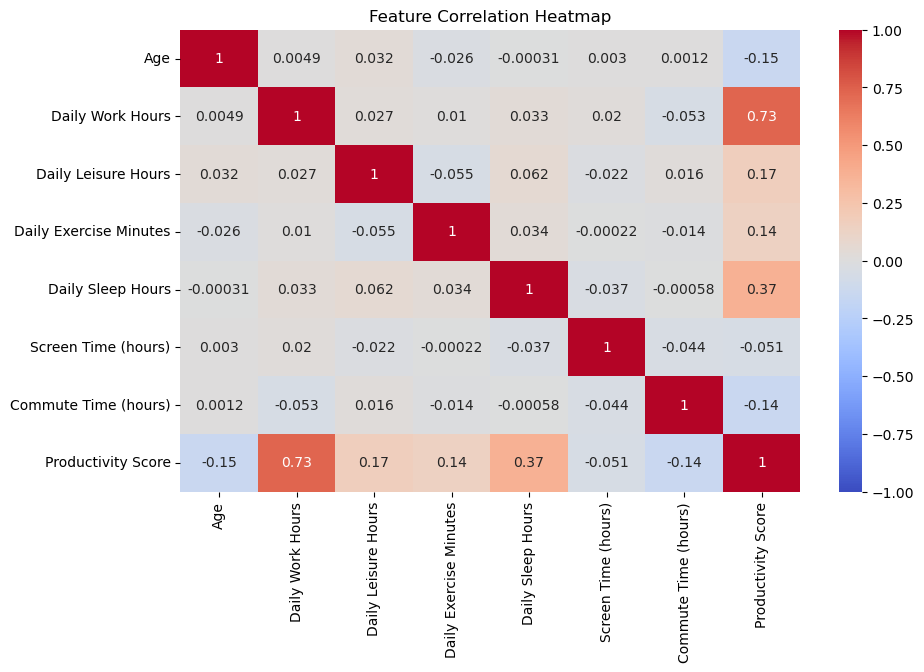

In [204]:
plt.figure(figsize=(10,6))
# sns.heatmap(data[features + ['Productivity Score']].corr(), annot=True, cmap='coolwarm')
sns.heatmap(features.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

## 2. Use case: Showing other similar learners

– About: This use case aims to cluster our users based on their time management and productivity patterns to facilitate the formation of study groups or peer networks. So that, users with similar studying habits can connect, share tips, and collaborate effectively.

– Tasks: The following section performs `K-Means clustering` to group our users.

In [205]:
wcss = []
# Elbow method (to find optimal number of K)
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

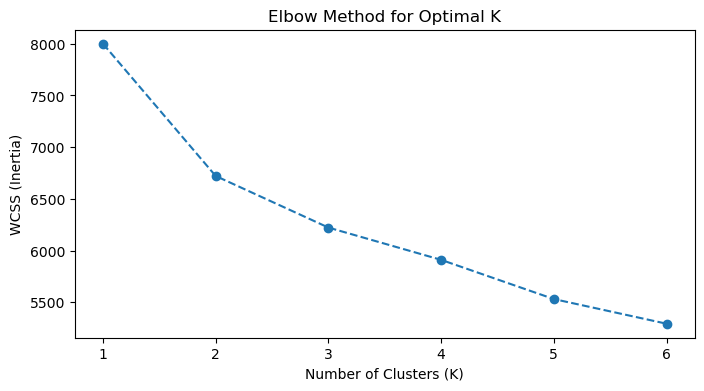

In [206]:
# Plot Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(range(1, 7), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [207]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
data['Cluster'] = clusters

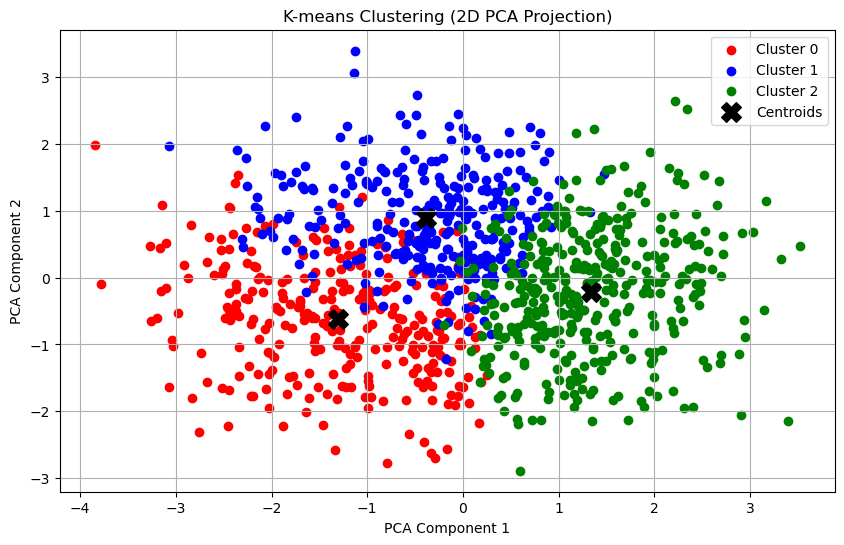

In [208]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']  # Adjust for k
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                c=colors[i], label=f'Cluster {i}')

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering (2D PCA Projection)')
plt.legend()
plt.grid()
plt.show()

In [209]:
data.groupby('Cluster').mean().T.round(2)

Cluster,0,1,2
Age,40.29,41.19,38.82
Daily Work Hours,5.88,6.28,8.49
Daily Leisure Hours,1.69,3.82,2.79
Daily Exercise Minutes,67.23,47.22,68.81
Daily Sleep Hours,6.33,7.04,7.31
Screen Time (hours),3.64,3.27,3.43
Commute Time (hours),1.05,1.16,0.82
Productivity Score,12.79,15.13,19.60


### Insights about clusters

Cluster 0: The "In-progress learners"
- Work-Life Balance: Moderate work hours (~5.9 hrs/day) but very low leisure time (1.7 hrs/day).
- Health & Sleep: Below-average sleep (6.3 hrs) and moderate exercise (~67 mins).
- Productivity: Lowest productivity (~12.8), possibly due to high screen time (3.6 hrs) and longer commutes (~1.05 hrs).

Recommendation: These users may struggle with burnout. Encourage better leisure/sleep habits and time-management strategies.

Cluster 1: The "Balanced Achievers"
- Work & Leisure: Slightly higher work hours (~6.3 hrs/day) but more leisure time (3.8 hrs/day).
- Health & Sleep: Best sleep (~7 hrs) and moderate exercise (~47 mins).
- Productivity: Mid-range (~16.3), likely due to balanced routines.

Recommendation: Ideal for peer mentoring—they manage work and personal time effectively.

Cluster 2: The "High-Performance Workers"
- Work Intensity: Highest work hours (~8.5 hrs/day) with moderate leisure (~2.8 hrs).
- Health & Sleep: Adequate sleep (~7.3 hrs) and high exercise (~69 mins).
- Productivity: Highest (~20.7), suggesting efficient routines despite busy schedules.

Recommendation: Group them for productivity hacks, but monitor for overwork risks.

## 3. Use case: Providing time management tips and learning strategies

– About: This use case aims to provide users with suggestions to improve their time management and learning strategies. Before doing so, the system will analyze key learning-related factors that may significantly influence the user's `Productivity Score`.

– Tasks: The following section performs an `MLR-OLS analysis` to identify the most important factors. Based on this analysis, a regression model will be built to predict each user's `Productivity Score`.

### 3.1 MLR-OLS analysis

In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features
sel_features = ['Age', 'Daily Work Hours', 'Daily Leisure Hours', 'Daily Exercise Minutes',
            'Daily Sleep Hours', 'Screen Time (hours)', 'Commute Time (hours)']
X = data[sel_features]
y = data['Productivity Score']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Productivity Score   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     278.4
Date:                Wed, 09 Apr 2025   Prob (F-statistic):          1.23e-208
Time:                        00:59:52   Log-Likelihood:                -1682.4
No. Observations:                 800   AIC:                             3381.
Df Residuals:                     792   BIC:                             3418.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

**Note:** This model uses input variables such as daily work hours, leisure time, exercise minutes, sleep hours, screen time, commute time, and age to predict the output variable Productivity Score.
It applies a Multiple Linear Regression model using Ordinary Least Squares (OLS).
The model achieves an R-squared of 0.711, indicating that approximately 71.1% of the variability in productivity scores can be explained by the selected input features.

### 3.2 MLR Model Coefficients

In [269]:
# Print model coefficients
coef_df = pd.DataFrame({
    'Feature': mlr_model.params.index,
    'Coefficient': mlr_model.params.values,
    'P-value': mlr_model.pvalues
})
display(coef_df.sort_values(by='Coefficient', ascending=False))

,Feature,Coefficient,P-value
Daily Work Hours,Daily Work Hours,1.529727,4.673352e-172
Daily Sleep Hours,Daily Sleep Hours,1.036510,1.792315e-56
Daily Leisure Hours,Daily Leisure Hours,0.385751,1.705470e-12
Daily Exercise Minutes,Daily Exercise Minutes,0.014234,2.174092e-11
Age,Age,-0.046934,1.706732e-14
Screen Time (hours),Screen Time (hours),-0.131061,8.123756e-03
Commute Time (hours),Commute Time (hours),-0.669521,4.761823e-08
const,const,-0.692175,2.680861e-01


**Note:** 
- According to the results, the p-values from the t-tests are close to 0, indicating that all seven features have a statistically significant impact on the model's performance. 
- This insight helps us identify which features are most important for our machine learning use case.  
- For example, **Daily Work Hours** has a coefficient of 1.53 and a p-value of 4.67e-172, which shows that working hours strongly affect the productivity score, and this result is highly unlikely to occur by chance.  
- These statistically significant variables should be prioritized in feature selection and model interpretation.


### Plot significant coefs
- Blue bars: The true coefficients you defined when generating productivity_score.
- Gray bars: The estimated coefficients learned from the OLS regression.
- Red dashed line: Helps visualize positive vs. negative contributions.

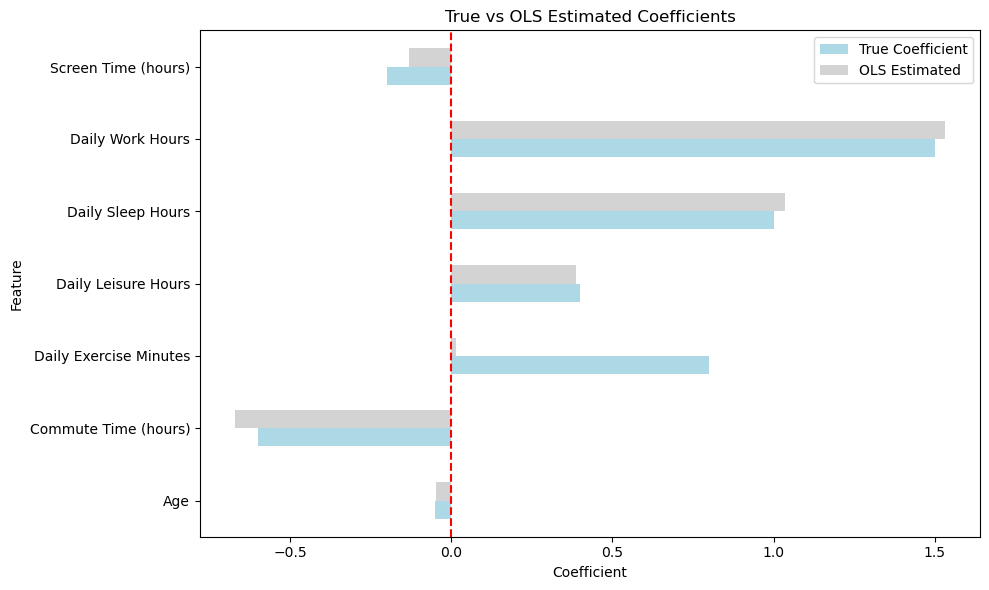

In [ ]:
# Ground truth coefficients used when generating the synthetic data
true_coefs = {
    'Daily Work Hours': 1.5,            # More work hours can increase productivity
    'Daily Sleep Hours': 1.0,           # Better sleep supports better focus and output
    'Daily Exercise Minutes': 0.8,      # Physical activity improves energy and alertness
    'Daily Leisure Hours': 0.4,         # Moderate leisure helps reduce stress
    'Commute Time (hours)': -0.6,       # Longer commutes reduce time and energy for work
    'Age': -0.05,                       # Slight decline in productivity with age
    'Screen Time (hours)': -0.2,        # Excessive screen time may distract or tire users
}

# Estimated coefficients from the OLS regression model
ols_coefs = mlr_model.params.drop('const')  # Drop the intercept

# Combine both into a single DataFrame for comparison
compare_df = pd.DataFrame({
    'True Coefficient': pd.Series(true_coefs),
    'OLS Estimated': ols_coefs
})

# Plot a horizontal grouped bar chart
compare_df.plot(kind='barh', figsize=(10, 6), color=['lightblue', 'lightgray'])
plt.axvline(0, color='red', linestyle='--')  # Add vertical line at zero
plt.title('True vs OLS Estimated Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Note:**  
– The model successfully learns the coefficient patterns for most features, except for **Daily Exercise Minutes**.  
– Based on the results, we can understand which time-related factors positively influence productivity. **Working hours**, **sleep hours**, and **leisure hours** all contribute positively, while **commute time** appears to have a negative impact on the output.  
– Therefore, we can share these insights and provide suggestions tailored to individual users. For example, we could calculate the ratio of commute time to working hours. If we find that some users spend too much time commuting rather than working or sleeping, we might recommend adjusting their daily routines — or suggest adding meaningful activities during transit, such as listening to podcasts.


### 3.3 Evaluation on testing set

In [278]:
y_test_pred = mlr_model.predict(sm.add_constant(X_test))

print("MLR R2 Score:", r2_score(y_test, y_test_pred))
print("MLR MSE:", mean_squared_error(y_test, y_test_pred))

MLR R2 Score: 0.7602967230177151
MLR MSE: 3.620144622544292


**Note:** The model performs well on the testing set, explaining **76% of the variance** in the test data (R² = 0.76).  
This suggests that the multiple linear regression model generalizes effectively and retains high predictive power on unseen data.  
The **mean squared error (MSE)** is **3.62**, meaning that the average squared difference between predicted and actual productivity scores is relatively low.


## Summary
- This document presents two ML use case for our project: **Showing other similar learners** and **Providing time management tips and learning strategies**.
- We generated a dataset for our ML use cases by assuming a potential pattern between learning habits and productivity scores.  
- Clustering is performed for **Showing other similar learners**, helping our product group users based on behavioral similarity.  
- MLR regression is used for **Providing time management tips and learning strategies**, allowing us to suggest personalized improvements to users' learning routines.